# Time series graph of mentions and story units by geographic scale

The current page shows a visualization of story units and place mentions by geographic scale, for each of 10 life stories.

to start, we import the needed python libraries:

In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.lines import Line2D
import glob as gl

import data that was processed and exported from dataframe_processing_and_export.ipynb

In [2]:
#fetch story data from csv files stored in /documents and with filename format "initials_type.csv" (e.g. og_pm, og_su). Store the fetched data as pandas dataframes inside dictionary d
storydata1 = gl.glob('EXPORT/*_pm.csv')
storydata2 = gl.glob('EXPORT/*_su.csv')

d1 = {}
d2 = {}

#load csvs as dataframes into a dictionary
for story in storydata1:
    d1[story[7:12]] = pd.read_csv(story, sep=',', encoding='latin-1')

for story in storydata2:
    d2[story[7:12]] = pd.read_csv(story, sep=',', encoding='latin-1')

format some columns

In [3]:
def timeVals(name, df):
    if name[-2:] == 'pm':
        df['time'] = pd.to_datetime(df.time, format='%Y-%m-%d %H:%M:%S')
    else:
        df['time_start'] = pd.to_datetime(df.time_start, format='%Y-%m-%d %H:%M:%S')
        df['time_end'] = pd.to_datetime(df.time_end, format='%Y-%m-%d %H:%M:%S')
        
for k, v in d1.items():
    timeVals(k, v)

for k, v in d2.items():
    timeVals(k, v)

Here are some variables and functions we will need during the graph-creation process:

In [4]:
#the colour choices for when the data is in a default or 'selected' state
pm_color = '#cccccc'
su_color = '#bdd7e7'
pm_color_alt = '#252525'
su_color_alt = '#08519c'

#this function is what actually puts the data onto the graph
def generateVspans(name1, df1, name2, df2, ax):
    for i in range(len(df2.index)):
        ax.axvspan(xmin = dates.date2num(df2.iloc[i]['time_start']), xmax = dates.date2num(df2.iloc[i]['time_end']), ymin = df2.iloc[i]['scale_order']/8-(1/8), ymax = df2.iloc[i]['scale_order']/8, facecolor = su_color, alpha = 1, zorder=2, picker=5, label=df2.iloc[i]['place'], gid = 'su')
    for i in range(len(df1.index)):
        ax.axvspan(xmin = dates.date2num(df1.iloc[i]['time'])-0.0001, xmax = dates.date2num(df1.iloc[i]['time'])+0.0001, ymin = df1.iloc[i]['scale_order']/8-(1/8), ymax = df1.iloc[i]['scale_order']/8, facecolor = pm_color, alpha = 1, zorder=3, picker=5, label=df1.iloc[i]['place'], gid = 'pm')

In [9]:
#the main plotting function

figure = {}

def plotAll(name1, df1, name2, df2):
    
    #for calculating fig x-axis length (to make it proportional to each story's timespan)
    xaxisTime = str(df2.iloc[[-1]]['time_end'])
    xaxisHour = int(xaxisTime[17:19])
    xaxisMin = int(xaxisTime[20:22])
    
    fig = plt.figure(num=None, figsize=(25, 7), dpi=80, facecolor='beige', edgecolor='k')
    ax = plt.axes([0.05,0.2,((xaxisHour+(xaxisMin/60))/10)*1.5,0.7], xmargin=0.0, ymargin=0.0)
    
    invisible_plot = ax.plot_date(x=df2.time_start, y=df2.scale_order, marker = '|', markersize=40, color='b', alpha=0, zorder=3)#use time span of su data since they represent entire span of interview.
    mainplot = generateVspans(name1, df1, name2, df2, ax)
    
    xmin, xmax = fig.get_children()[1].get_xlim()
    ymin, ymax = fig.get_children()[1].get_ylim()
    
    legend_elements = [Line2D([0], [0], color=pm_color, lw=0.5, label='Place mention'), Line2D([0], [0], color=su_color, lw=5, label='Story unit', alpha=1)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1.15))
    plt.title(name1[:2].upper(), y=1.02, x=0.1, fontsize = 35, color='gray')

    ax.set_xlabel('discourse time (hh:mm:ss)', fontsize=14, color='gray')
    ax.set_ylabel('geographic scale', fontsize=14, color='gray')

    hours = dates.HourLocator()
    minutes = dates.MinuteLocator(byminute=[15,30,45], interval=1)
    hoursFmt = dates.DateFormatter('%H:%M:%S')

    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(hoursFmt)
    ax.xaxis.set_minor_locator(minutes)

    ylocs = ax.set_yticks([2,3,4,5,6,7,8,9], minor=False)
    ylabels = ax.set_yticklabels(['journey','very local','local','city / area','region','country','continent','none'], minor=False)

    ax.xaxis.grid(color='#D3D3D3', linestyle='dashed', linewidth=0.5, zorder = 1)
    ax.hlines(y = [2,3,4,5,6,7,8,9], xmin = xmin, xmax = xmax, color='#D3D3D3', linestyle='dashed', linewidth=0.5, zorder = 1)

    plt.xticks(rotation=45)
    
    #the click function
    def onPick(event):
        
        mouseevent = event.mouseevent
        artist = event.artist
        lab = artist.get_label()
        gid = artist.get_gid()
        
        x_data = mouseevent.xdata
        y_data = mouseevent.ydata
        
        #delete previously-added onpick vlines and text
        del fig.axes[0].collections[0]
        
        #newtext = ax.text(x_data, y_data, lab, fontsize=12, gid = 'newtext')
        newtext = ax.annotate(lab, (0.2, 1.1), xycoords = 'axes fraction',fontsize=14, gid = 'text', color = 'k', backgroundcolor = 'white')
        #generate and add vlines around clicked element
        artists = fig.axes[0].get_children()
        
        vline_x1 = artist.xy[0][0]
        vline_x2 = artist.xy[2][0]
        newlines = ax.vlines(x = [vline_x1, vline_x2], ymin = ymin, ymax = 9, color='k', linestyle='dashed', linewidth=0.5, zorder = 6, gid = 'newlines')
        
        #toggle colors of other artists that have the same 'place' label
        for a in artists:
            try:
                lab_other = a.get_label()
                gid_other = a.get_gid()
                #revert altered colors to original colors
                if gid_other[3:] == 'alt':
                    a.set_gid(gid_other[:2])
                    if a.get_gid() == 'pm':
                        a.set_color(pm_color)
                        #artist.set_zorder(3)
                    else:
                        a.set_color(su_color)
                        #artist.set_zorder(2)
                #change colors if matching place label of clicked element
                elif lab_other == lab:
                    if gid_other == 'pm':
                        a.set_color(pm_color_alt)
                        #artist.set_zorder(5)
                    else:
                        a.set_color(su_color_alt)
                        #artist.set_zorder(4)
                    a.set_gid(gid_other+'_alt')
                else:
                    pass
            except TypeError:
                continue
                
        #adding code within function after the for loop seems to mess things up
        
    connection_id2 = fig.canvas.mpl_connect('pick_event', onPick)
    #https://stackoverflow.com/questions/24960910/how-can-i-pass-parameters-to-on-key-in-fig-canvas-mpl-connectkey-press-event/24960937
    #connection_id3 = fig.canvas.mpl_connect("motion_notify_event", lambda event: hover(event, mainplot, annot))
    
    #store figure in dict variable
    figure[name1[:2]] = fig
    

call graph-making functions

<IPython.core.display.Javascript object>


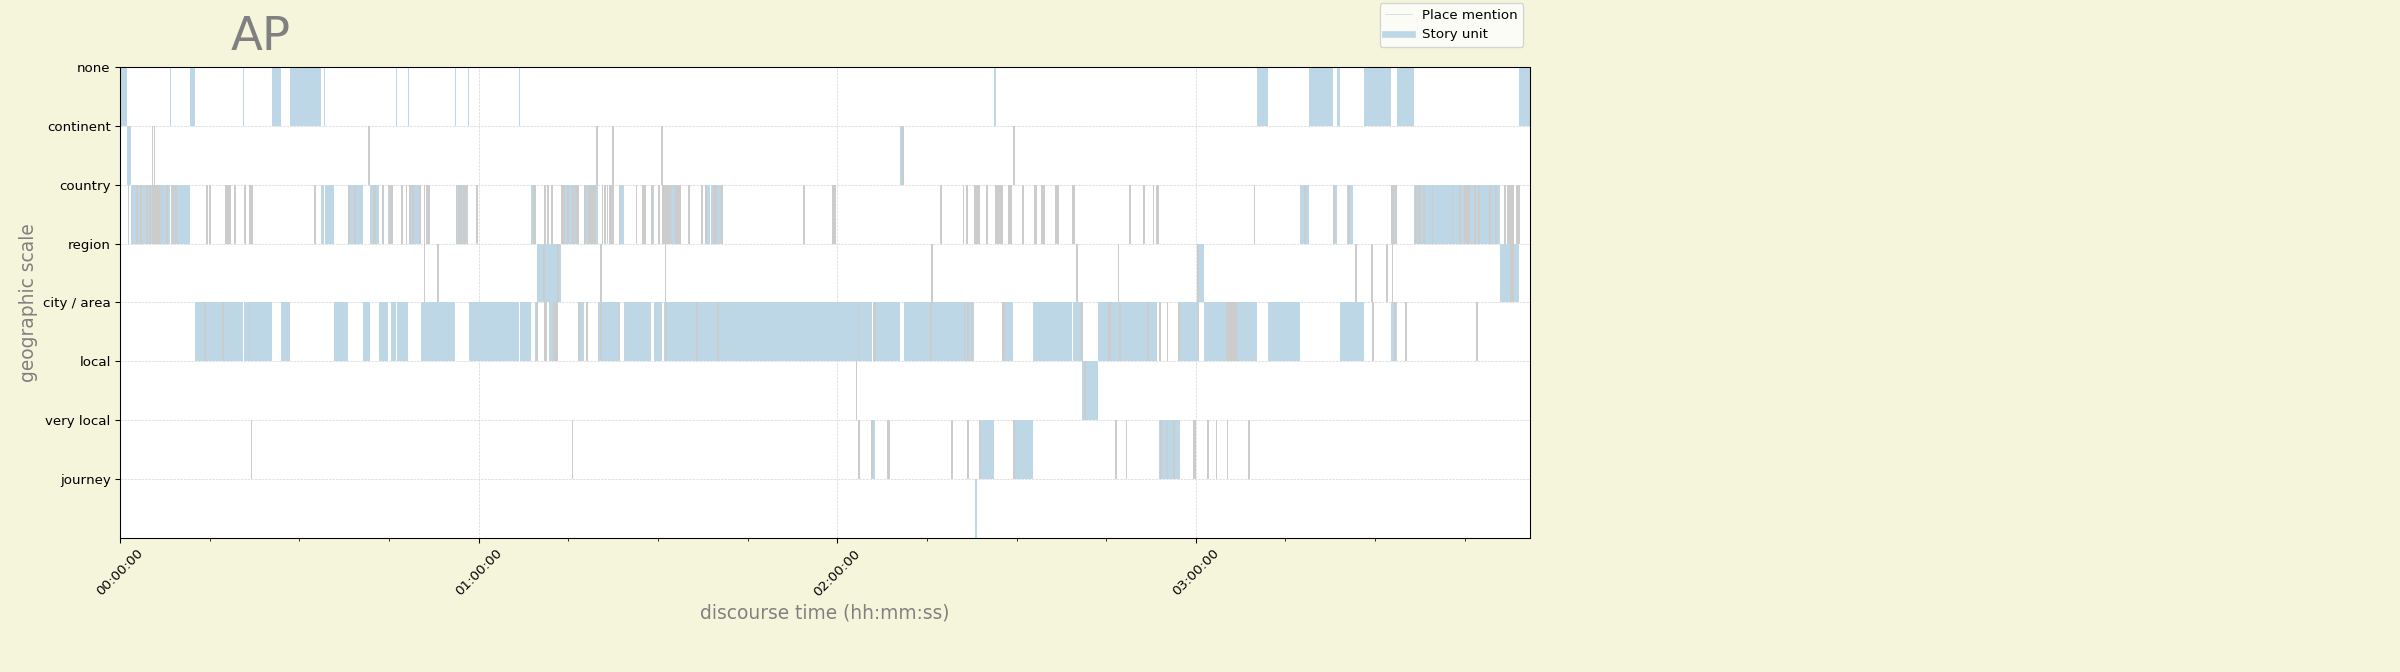

<IPython.core.display.Javascript object>


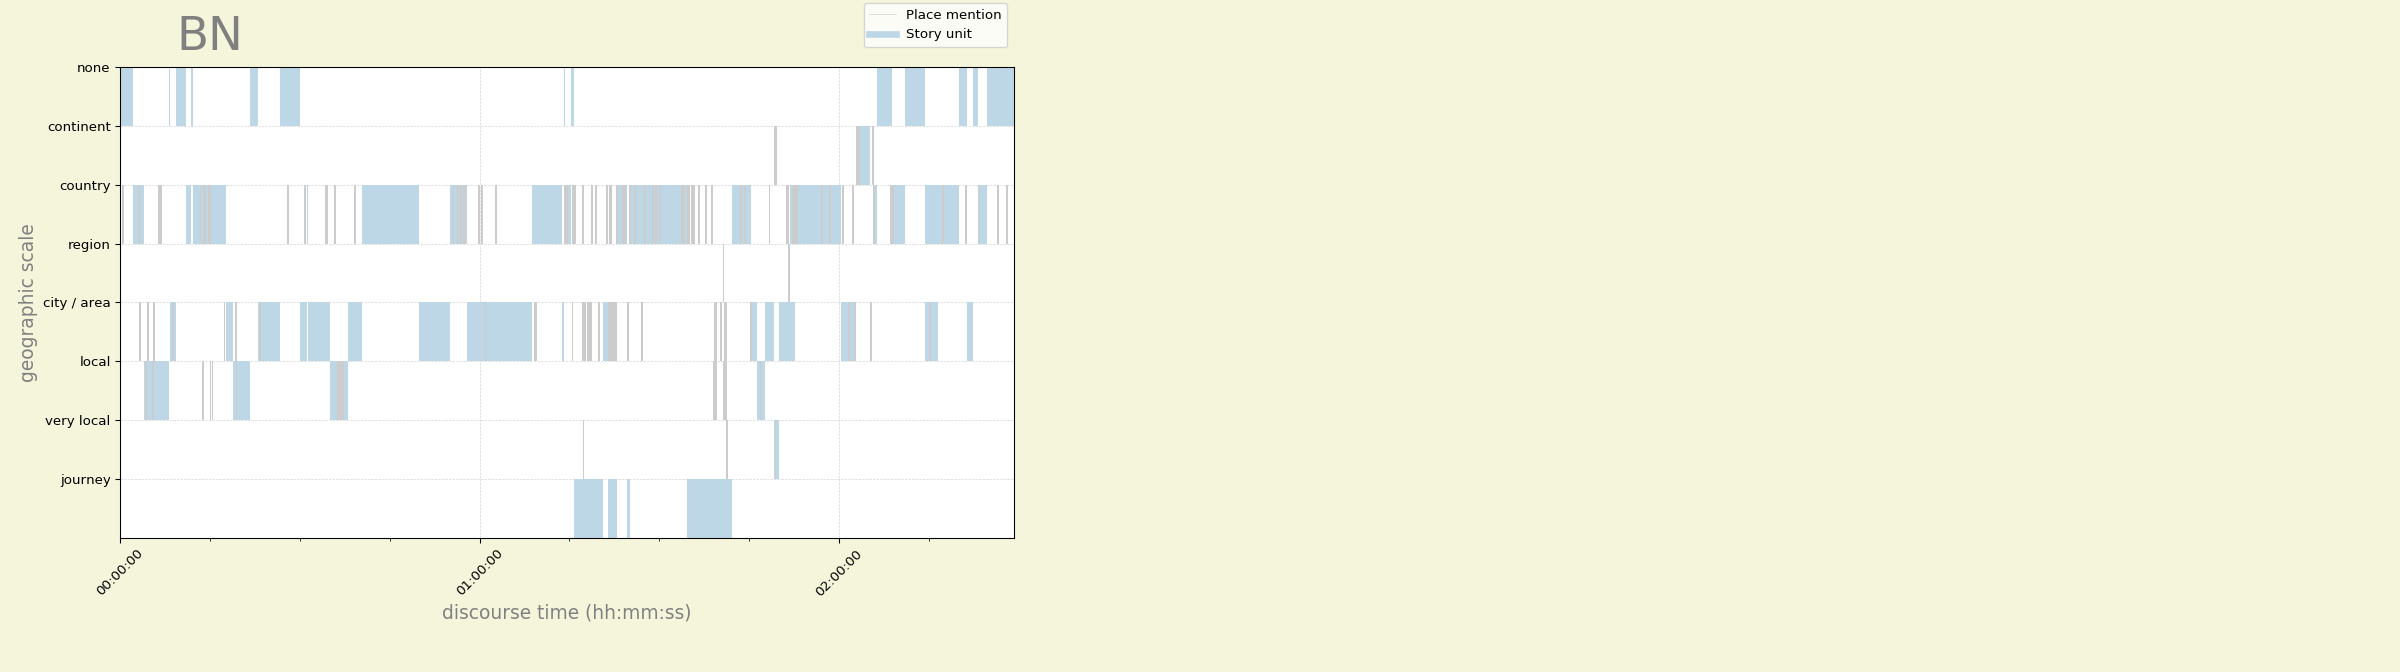

<IPython.core.display.Javascript object>


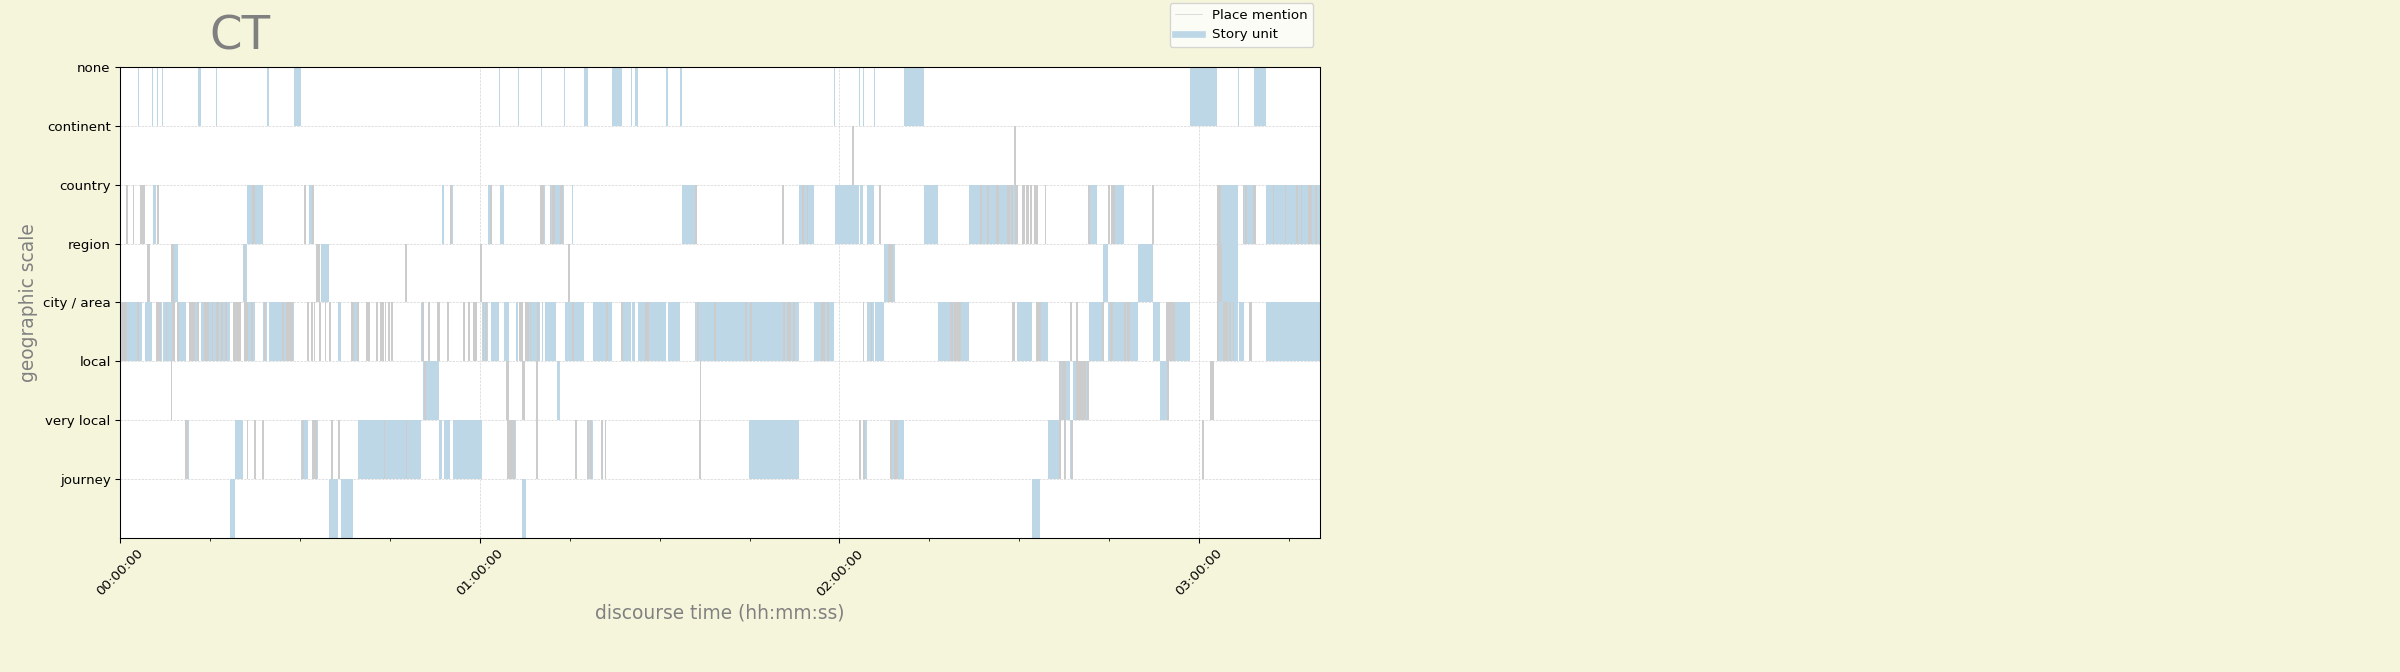

<IPython.core.display.Javascript object>


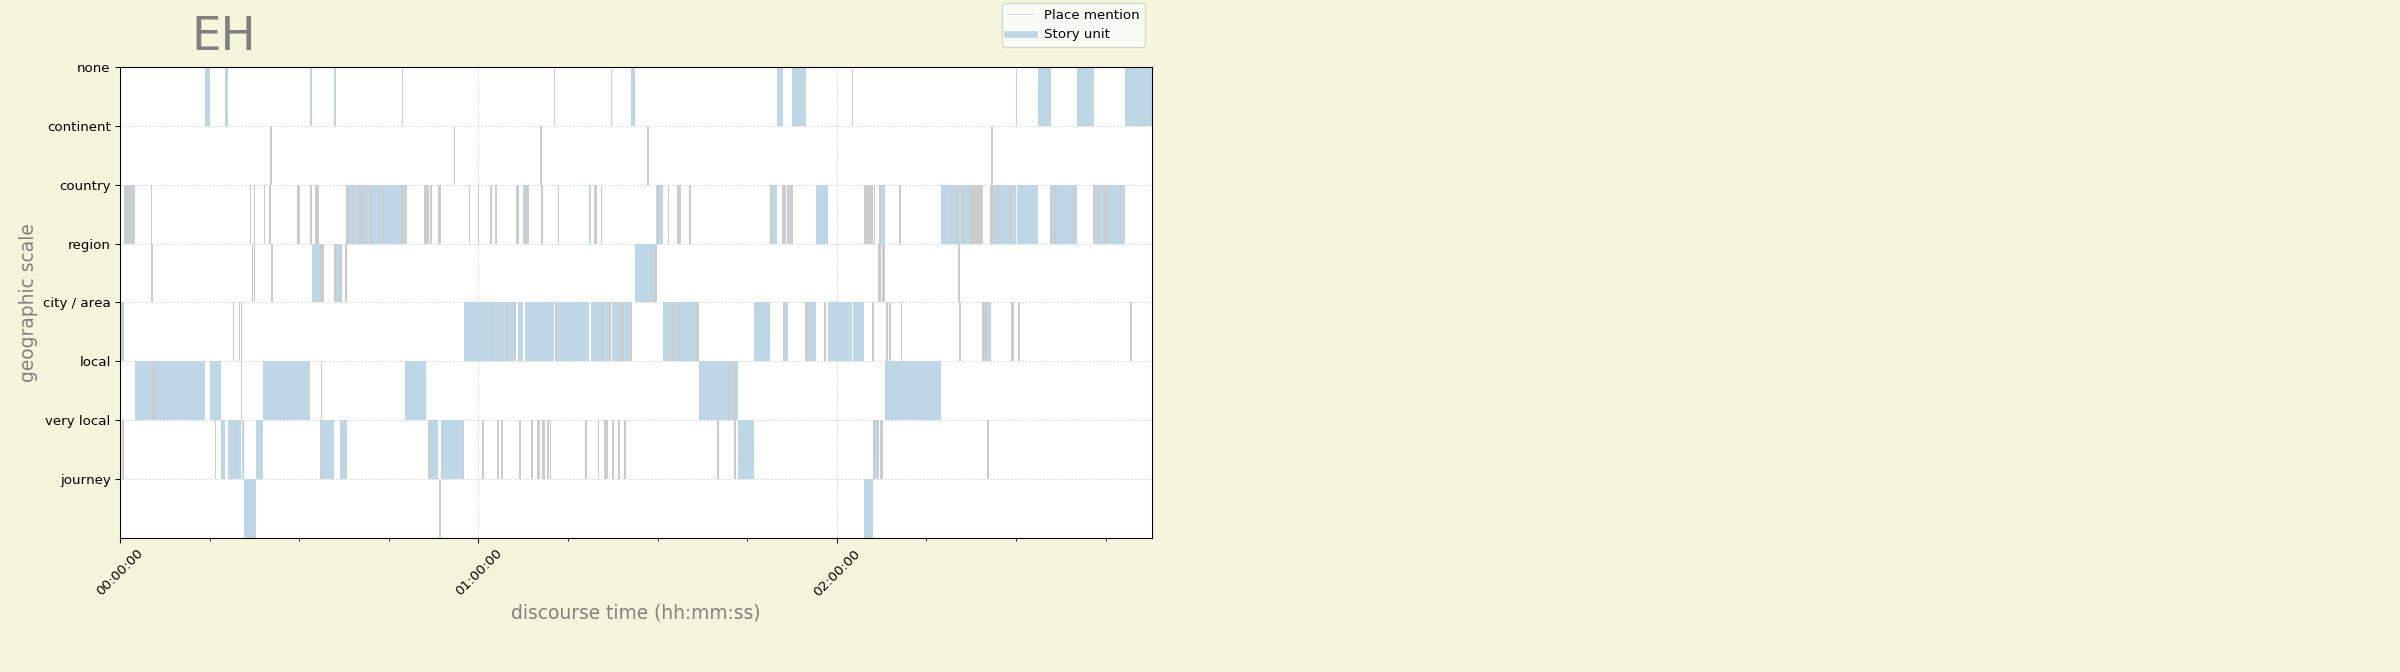

<IPython.core.display.Javascript object>


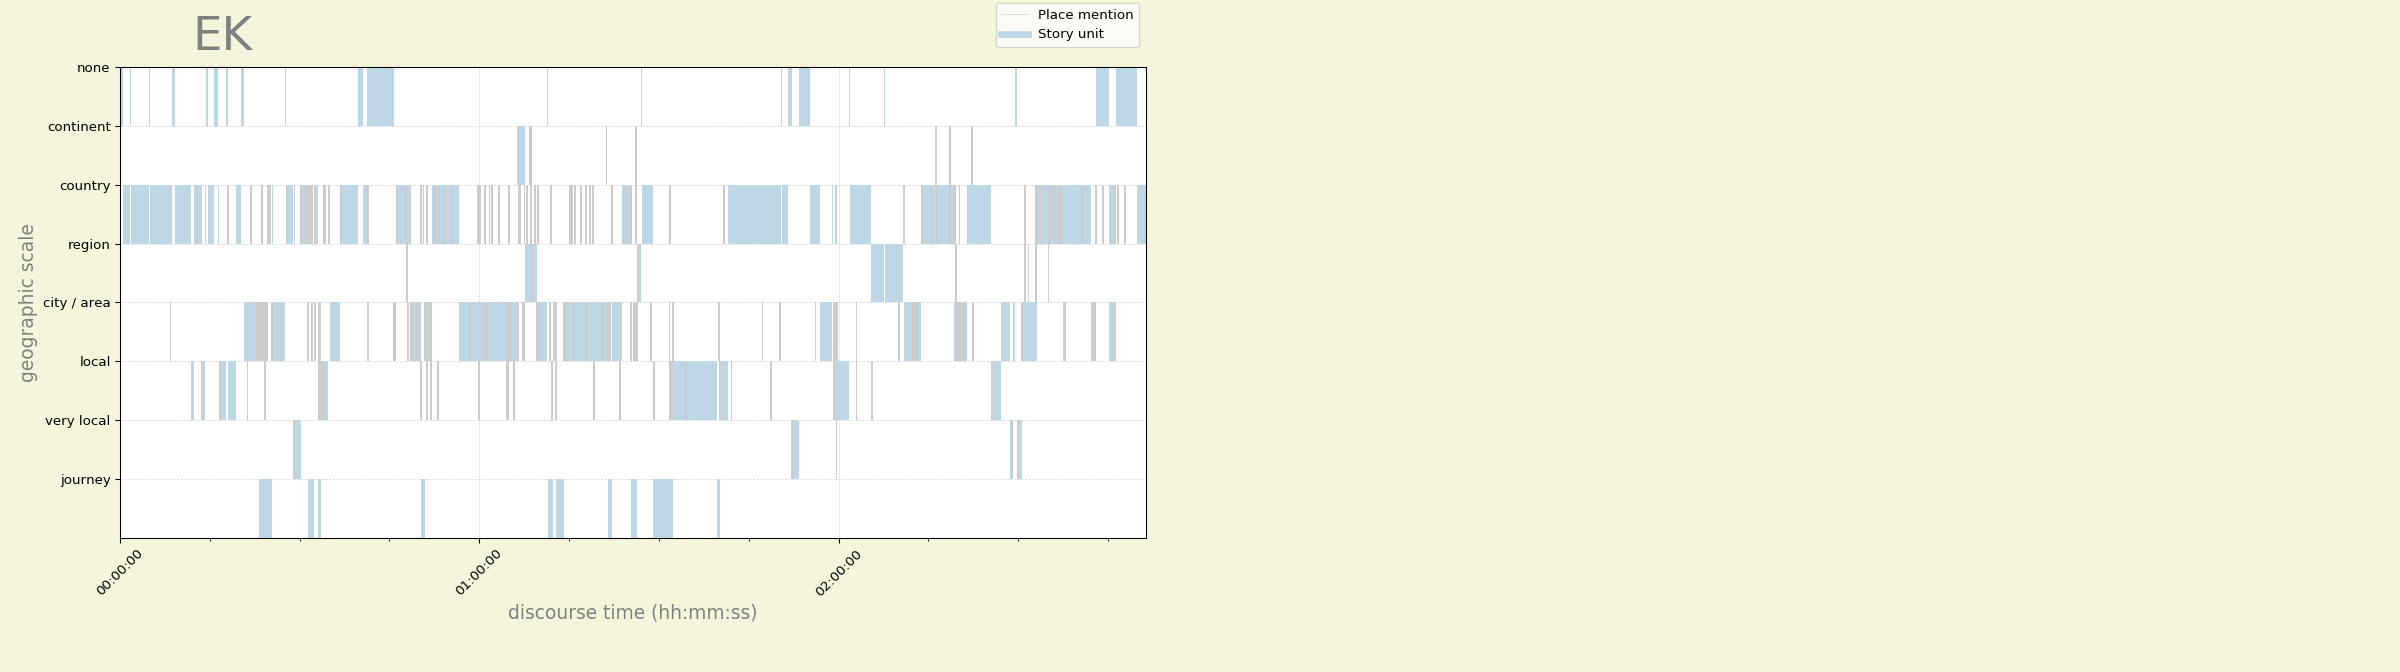

<IPython.core.display.Javascript object>


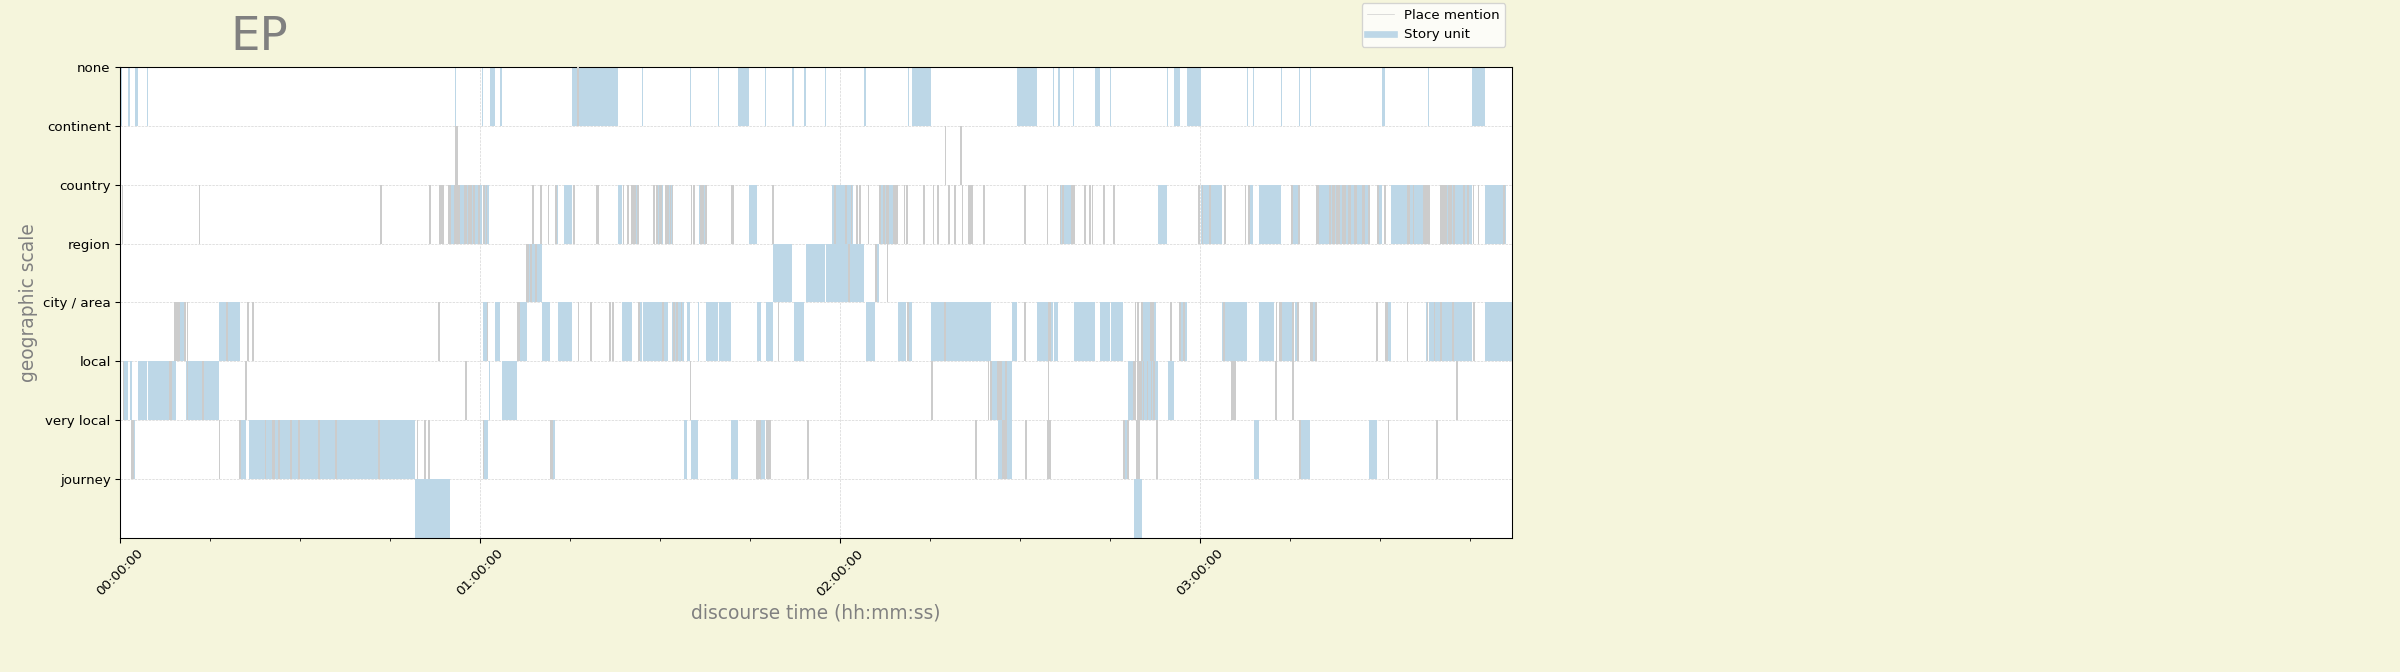

<IPython.core.display.Javascript object>


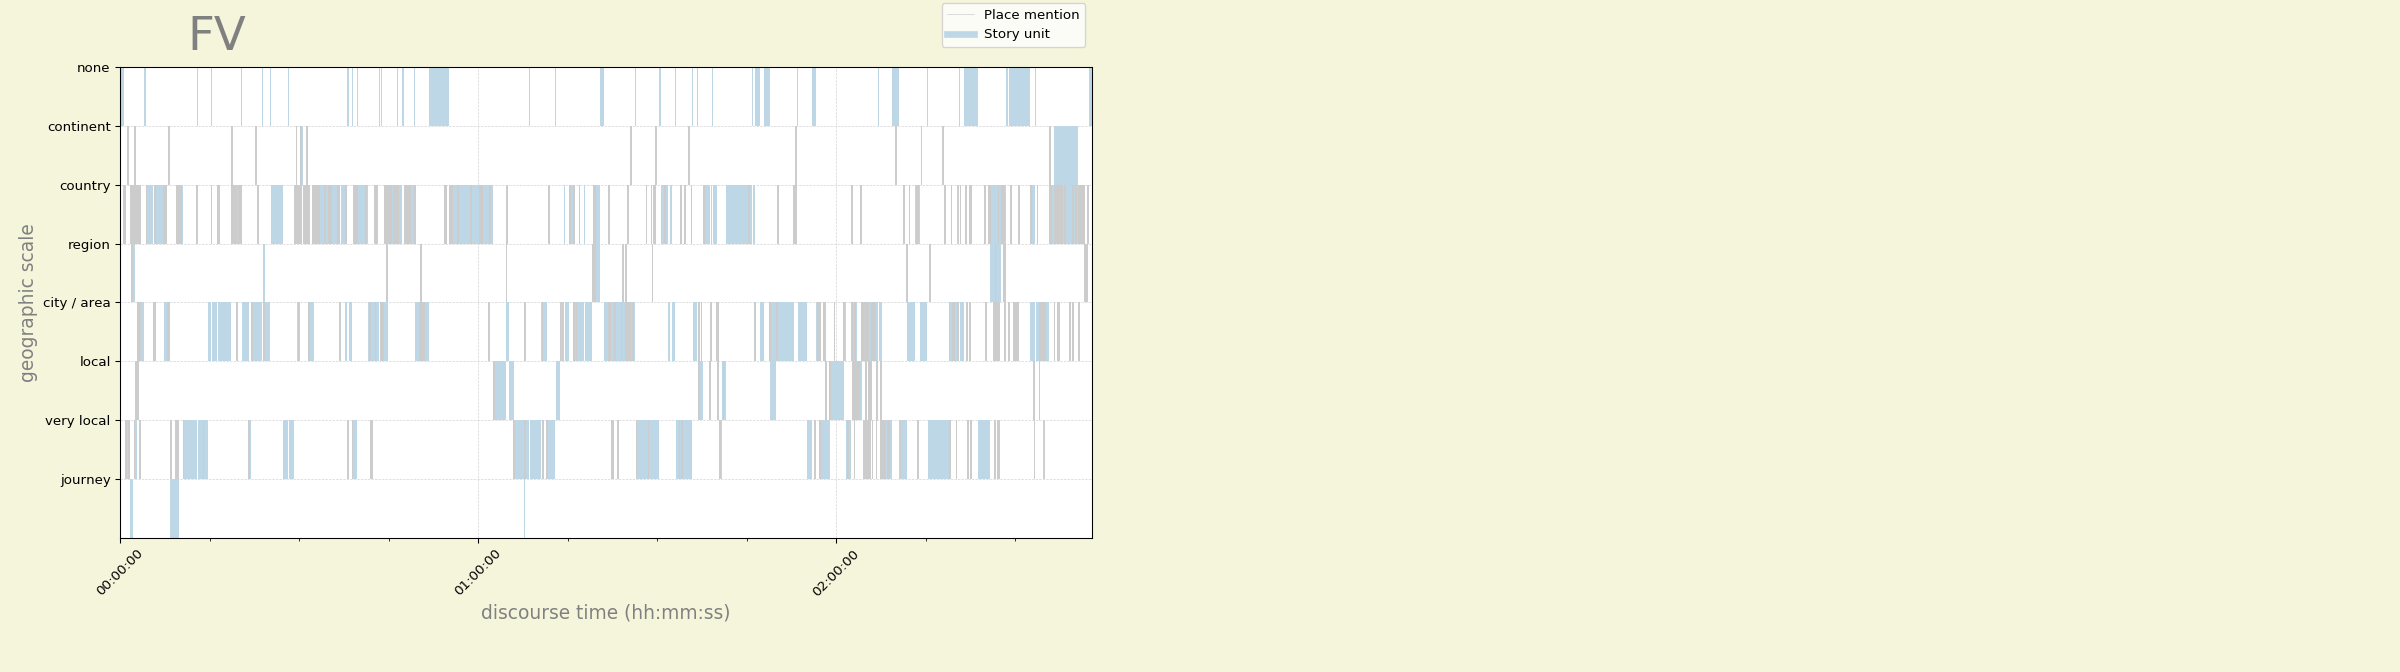

<IPython.core.display.Javascript object>


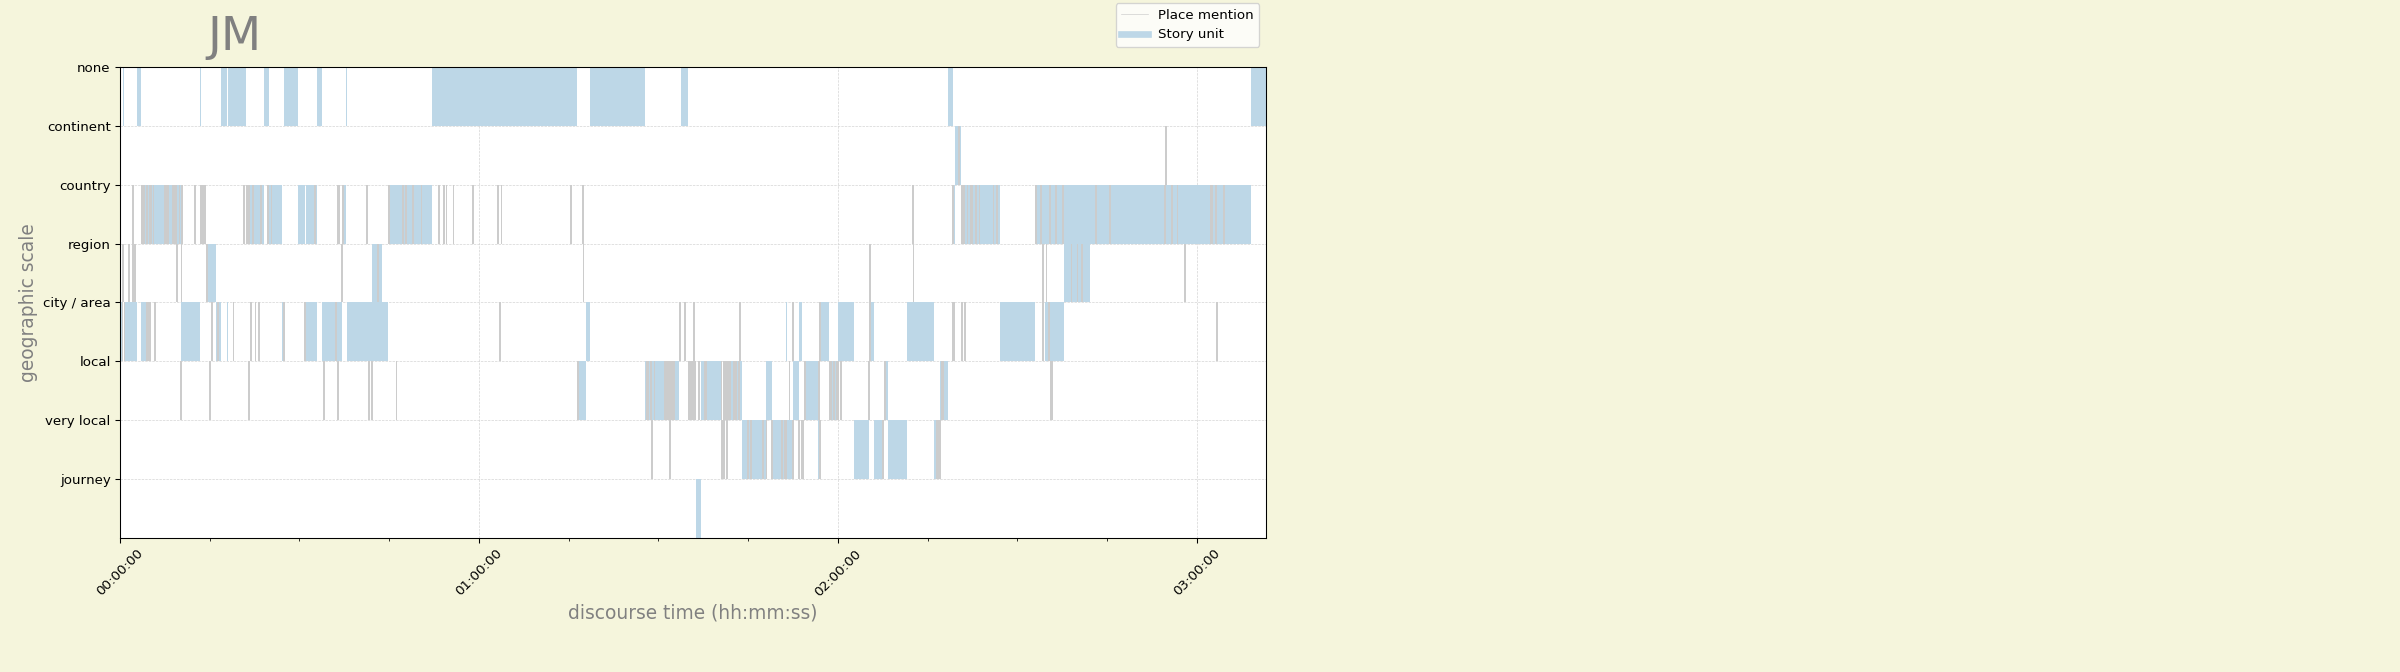

<IPython.core.display.Javascript object>


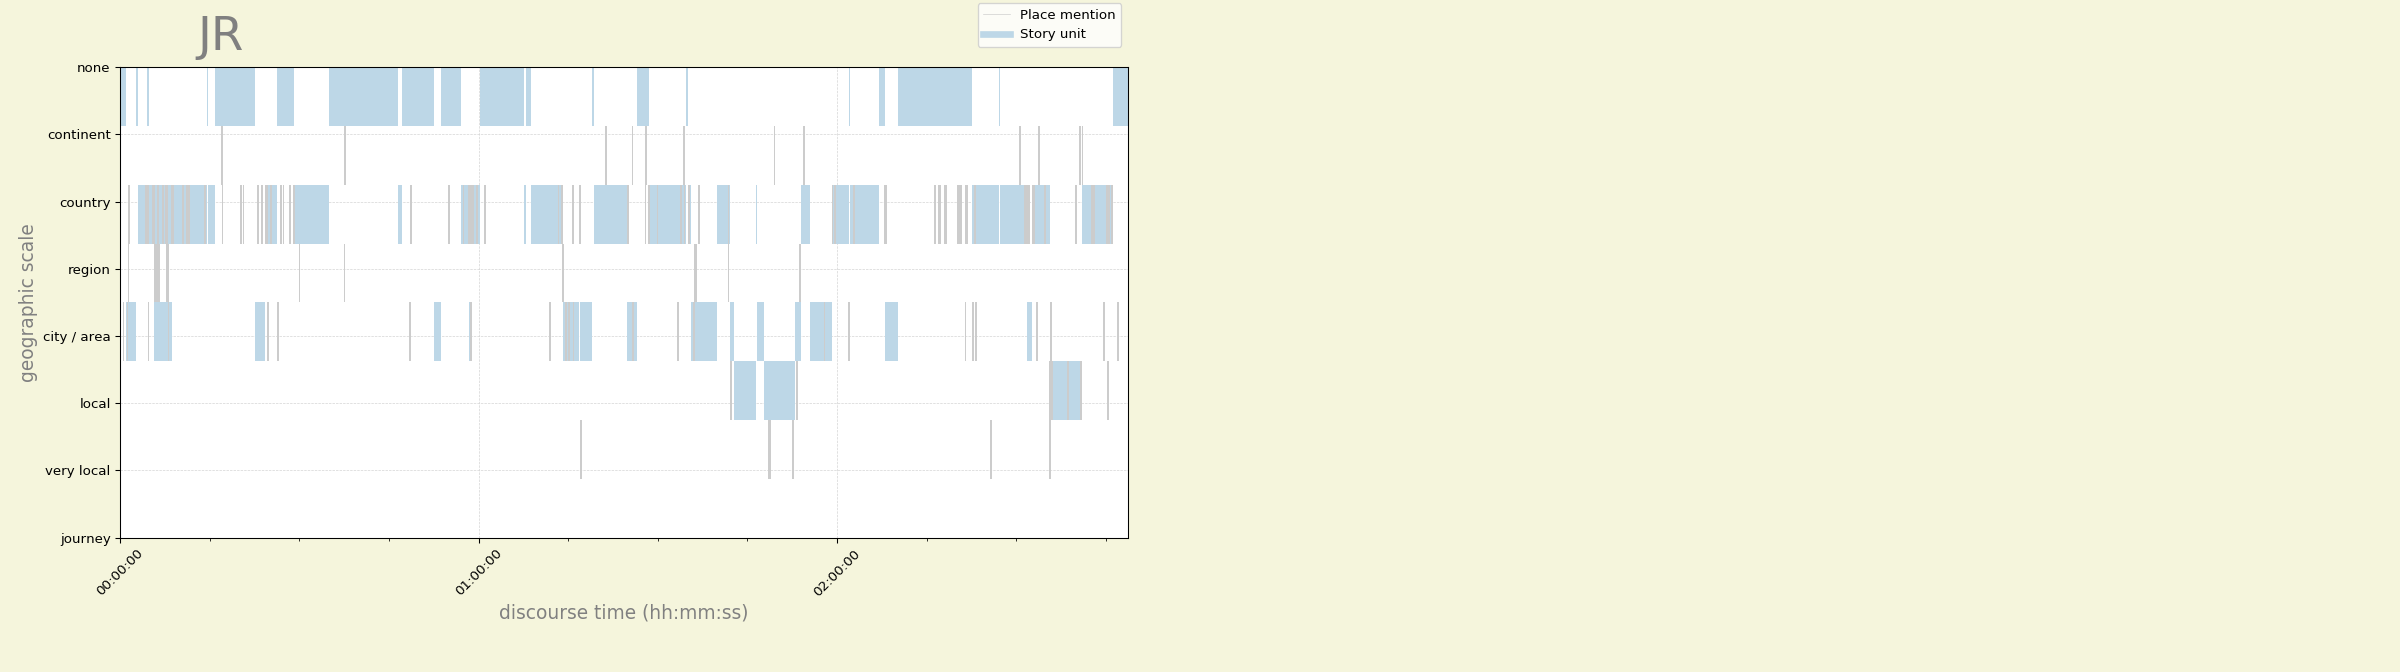

<IPython.core.display.Javascript object>


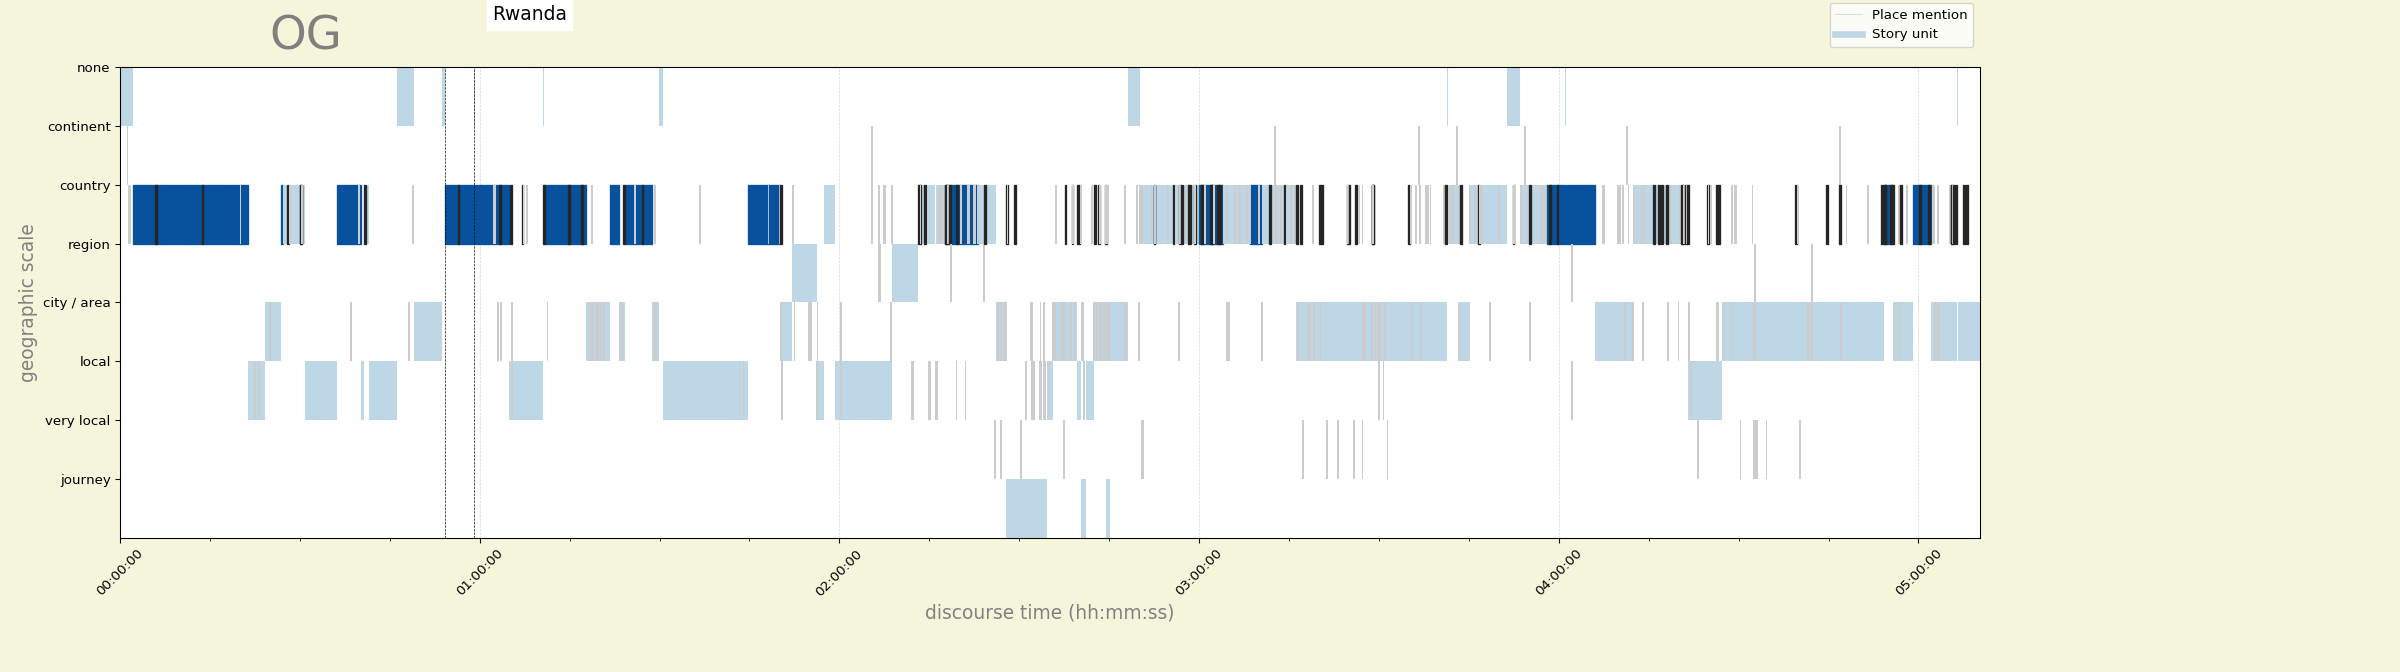

In [10]:
#each plot requires both the pm dataframe and su dataframe

for (k1, v1), (k2, v2) in zip(sorted(d1.items()), sorted(d2.items())):
    plotAll(k1, v1, k2, v2)

the graphs take a fixed width of 25 inches (units tbd), and calculate the length of the graph (x axis) as a proportion of this fixed viewpane. Thus, for example, OG's story, which is 5.13 hours long, takes up 51.3% of the width of the viewpane, multiplied by 1.5 to take up roughly 75% of the viewpane. In this way, each graph's x-axis length (plot width) appears proportional to the story's length (note that there are still very minute differences in absolute distance between hour-tick marks on the x-axis between graphs, whic has yet to be corrected).

- "Multi-place" story units are disaggregated into their respective places, each presented within its respective 'scale' category. Each place spans the whole timespan of the story unit from which it came.
- Because "Journey" story units tend to represent a consecutive series of places (movement between them in a single direction), they are not disaggregated in the same way as "multiplace" story units, and are instead presented as their own "journey" scale category.

scraps

In [ ]:
#artists = figure['ap'].axes[0].get_children()
#gid_o = artists[100].get_gid()
#artists[100].set_gid(gid_o+"_alt")
#artists[100].get_gid()[3:]

#hi = figure['ap'].axes[0].get_children()
#del artists[0]
#artists
#figure['jm'].axes[0].get_children().remove('Text')
"""
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

i = 0
testerr = {}
for i in range(440):
    hi = figure['og'].axes[0].get_children()[i].get_gid()
    testerr[i] = hi
    i+=1
#figure['fv'].axes[0].lines[0].properties()['color']
#artists

del(d1['bn_pm'])
del(d1['ek_pm'])
del(d1['ct_pm'])
del(d1['eh_pm'])
del(d1['ap_pm'])
del(d1['ep_pm'])
del(d1['jm_pm'])
del(d1['jr_pm'])
del(d1['fv_pm'])
del(d2['bn_su'])
del(d2['ek_su'])
del(d2['ct_su'])
del(d2['eh_su'])
del(d2['ap_su'])
del(d2['ep_su'])
del(d2['jm_su'])
del(d2['jr_su'])
del(d2['fv_su'])
"""



